### Import the libraries and the data

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, auc, roc_auc_score, plot_confusion_matrix, SCORERS
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_selector as selector

np.random.seed(0)

In [171]:
train_df = pd.read_csv("../data/01_raw/attrition_train.csv")
test_df = pd.read_csv("../data/01_raw/attrition_test.csv")

### Get info about column names, missing values and Dtype

In [172]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1100 non-null   int64 
 1   Attrition                 1100 non-null   object
 2   BusinessTravel            1100 non-null   object
 3   DailyRate                 1100 non-null   int64 
 4   Department                1100 non-null   object
 5   DistanceFromHome          1100 non-null   int64 
 6   Education                 1100 non-null   int64 
 7   EducationField            1100 non-null   object
 8   EmployeeCount             1100 non-null   int64 
 9   EmployeeNumber            1100 non-null   int64 
 10  EnvironmentSatisfaction   1100 non-null   int64 
 11  Gender                    1100 non-null   object
 12  HourlyRate                1100 non-null   int64 
 13  JobInvolvement            1100 non-null   int64 
 14  JobLevel                

In [173]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       370 non-null    int64 
 1   BusinessTravel            370 non-null    object
 2   DailyRate                 370 non-null    int64 
 3   Department                370 non-null    object
 4   DistanceFromHome          370 non-null    int64 
 5   Education                 370 non-null    int64 
 6   EducationField            370 non-null    object
 7   EmployeeCount             370 non-null    int64 
 8   EmployeeNumber            370 non-null    int64 
 9   EnvironmentSatisfaction   370 non-null    int64 
 10  Gender                    370 non-null    object
 11  HourlyRate                370 non-null    int64 
 12  JobInvolvement            370 non-null    int64 
 13  JobLevel                  370 non-null    int64 
 14  JobRole                   

### Create X and y dataframes, split them into train and test, get the list of categorical and numeric features.

In [174]:
y = train_df.Attrition
X = train_df.drop(['Attrition'], axis=1)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

categorical_features = [cname for cname in X_train.columns if 
                    X_train[cname].dtype == "object"]
numeric_features = [cname for cname in X_train.columns if 
                    X_train[cname].dtype == "int64"]

### Preprocess the training data, create the classifier model and fit it with the data.

In [175]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=500, C=1, penalty='l2', solver='liblinear'))])

{'classifier__C': 1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}



clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.868


### Get an extended list of numeric features, with the One Hot encoded categorical features.

In [176]:
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

### Associate the features list to their coefficient in a dataframe, sorted in descending order.

In [177]:
coefs = clf.named_steps['classifier'].coef_
features_coef = pd.DataFrame(numeric_features_list)
features_coef['coef'] = pd.Series(coefs[0])
features_coef.rename(columns={0: "features"}, inplace=True)
features_coef.sort_values(by='coef', ascending=False)

,features,coef
27,BusinessTravel_Travel_Frequently,0.856613
54,OverTime_Yes,0.814649
48,JobRole_Sales Representative,0.723812
24,YearsSinceLastPromotion,0.711698
32,EducationField_Human Resources,0.685925
22,YearsAtCompany,0.424453
13,NumCompaniesWorked,0.402899
2,DistanceFromHome,0.397154
37,EducationField_Technical Degree,0.347087
51,MaritalStatus_Single,0.310205


In [178]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [179]:
f1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
roc_auc_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
precision_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
recall_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')


print("Average F1 scores:\n", f1_scores.mean())
print("Average roc auc scores:\n", roc_auc_scores.mean())
print("Average Precision scores:\n", precision_scores.mean())
print("Average Recall scores:\n", recall_scores.mean())


Average F1 scores:
 0.5913751817100569
Average roc auc scores:
 0.8499575226176213
Average Precision scores:
 0.7396825396825396
Average Recall scores:
 0.5064039408866995


### Recherche des paramètres du modèle de classification par une validation croisée

In [180]:
param_grid = {
    'classifier__C': [1, 10, 50, 65, 100],
    'classifier__penalty' : ['l2'],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag']

}


grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'EmployeeCount',
                                                                          'EmployeeNumber',
                                                                          'EnvironmentSatisfaction',
 

In [181]:
grid_search.best_params_

{'classifier__C': 1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [182]:
#pd.DataFrame(grid_search.cv_results_)

In [183]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__scaler', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__sparse', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__l1_ratio', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifie

In [184]:
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba

array([[9.65461157e-01, 3.45388430e-02],
       [7.81058010e-01, 2.18941990e-01],
       [9.92863483e-01, 7.13651653e-03],
       [9.23845056e-01, 7.61549442e-02],
       [9.41313662e-01, 5.86863383e-02],
       [9.84141410e-01, 1.58585897e-02],
       [9.29533580e-01, 7.04664201e-02],
       [9.86502155e-01, 1.34978446e-02],
       [9.79959208e-01, 2.00407924e-02],
       [9.31995467e-01, 6.80045334e-02],
       [9.73642915e-01, 2.63570849e-02],
       [8.63866790e-01, 1.36133210e-01],
       [3.31542112e-01, 6.68457888e-01],
       [9.91262804e-01, 8.73719552e-03],
       [3.99074098e-01, 6.00925902e-01],
       [9.79952285e-01, 2.00477151e-02],
       [9.82734365e-01, 1.72656347e-02],
       [7.42332140e-01, 2.57667860e-01],
       [9.56390900e-01, 4.36090998e-02],
       [9.69629287e-01, 3.03707131e-02],
       [8.81915975e-01, 1.18084025e-01],
       [8.39988927e-01, 1.60011073e-01],
       [8.34040396e-01, 1.65959604e-01],
       [7.13498427e-01, 2.86501573e-01],
       [9.727567

In [185]:
y_pred = clf.predict(X_test)

In [186]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [187]:
confusion_matrix(y_test, y_pred)

array([[176,   8],
       [ 21,  15]])

In [188]:
print("Sur les 220 salariés du jeu de données test :\n")
print("Le nombre de personnes qui ont quitté l'entreprise est : {}".format(fn + tp))
print("Le nombre de personnes dont on a prédit qu'il allaient quitter l'entreprise: {}".format(tp + fp))
print("Le nombre de personnes qui sont restées dans l'entreprise: {}".format(tn + fp))
print("Le nombre de cas total où on s'est trompé: {}".format(fn + fp))
print("Le nombre de cas où on s'est trompé sur des personnes qui avaient l'intention de partir: {}".format(fn))
print("Le nombre de cas où on s'est trompé sur des personnes qui voulaient rester: {}".format(fp))


Sur les 220 salariés du jeu de données test :

Le nombre de personnes qui ont quitté l'entreprise est : 36
Le nombre de personnes dont on a prédit qu'il allaient quitter l'entreprise: 23
Le nombre de personnes qui sont restées dans l'entreprise: 184
Le nombre de cas total où on s'est trompé: 29
Le nombre de cas où on s'est trompé sur des personnes qui avaient l'intention de partir: 21
Le nombre de cas où on s'est trompé sur des personnes qui voulaient rester: 8


### Calcul des métriques

In [189]:
print("Métriques calculées par sklearn.metrics\n")
print("Précision : %.3f" % precision_score(y_test, y_pred))
print("Accuracy : %.3f" % accuracy_score(y_test, y_pred))
print("Rappel (ou sensibilité) : %.3f" % recall_score(y_test, y_pred))
print("F-measure : %.3f\n" % f1_score(y_test, y_pred))

print("Métriques recalculées\n")
print("Précision : {}".format(tp /(tp + fp)))
print("Accuracy : {}".format((tp + tn) /(tp + fp + tn + fn)))
print("Rappel (ou sensibilité) : {}".format(tp /(tp + fn)))
print("Spécificité : {}".format(tn /(fp + tn)))
print("F-measure : {}\n".format(2*tp /(2*tp + fp + fn)))


Métriques calculées par sklearn.metrics

Précision : 0.652
Accuracy : 0.868
Rappel (ou sensibilité) : 0.417
F-measure : 0.508

Métriques recalculées

Précision : 0.6521739130434783
Accuracy : 0.8681818181818182
Rappel (ou sensibilité) : 0.4166666666666667
Spécificité : 0.9565217391304348
F-measure : 0.5084745762711864



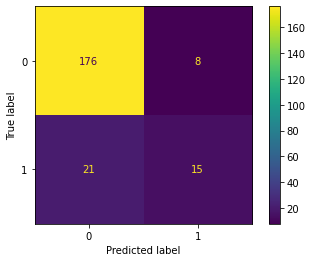

In [190]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show() 

On veut améliorer le rappel (recall) ou sensibilité et la précision.


Le rappel est intuitivement la capacité du classificateur à trouver tous les échantillons positifs.
Un mauvais rappel signifie dans notre cas que nous avons sélectionné peu d'éléments pertinents et donc manqué de proposer le programme d'accompagnement à des personnes qui souhaitaient quitter l'entreprise.
Or, c'est précisément ce que nous ne voulons pas pour éviter le turn-over.

La précision est intuitivement la capacité du classificateur à ne pas étiqueter comme positif un échantillon qui est négatif.
Dans notre cas, une mauvaise précision nous fera inscrire au programme d'accompagnement des personnes qui ne souhaitaient pas quitter l'entreprise, ce qui occasionera un coût non nécessaire, en plus de prendre des places qui auraient été plus utiles si elles avaient étaient attribuées aux personnes susceptibles de partir.


Le score F1 peut être interprété comme une moyenne pondérée de la précision et du rappel, où un score F1 atteint sa meilleure valeur à 1 et son pire score à 0. La contribution relative de la précision et du rappel au score F1 est égale.


### Prédiction du taux d'attrition pour les employés de l'entreprise (fichier attrition_test.csv)

In [192]:
attrition_score_pred = clf.predict_proba(test_df)
attrition_score_pred

/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


array([[2.26992081e-01, 7.73007919e-01],
       [9.89462677e-01, 1.05373228e-02],
       [7.83185430e-01, 2.16814570e-01],
       [9.28871955e-01, 7.11280452e-02],
       [9.80190454e-01, 1.98095458e-02],
       [8.93301450e-01, 1.06698550e-01],
       [9.73648616e-01, 2.63513836e-02],
       [9.79588209e-01, 2.04117915e-02],
       [5.39488885e-01, 4.60511115e-01],
       [8.41956380e-01, 1.58043620e-01],
       [2.92128553e-01, 7.07871447e-01],
       [5.74399085e-01, 4.25600915e-01],
       [9.98369665e-01, 1.63033464e-03],
       [9.87697860e-01, 1.23021400e-02],
       [7.63390755e-01, 2.36609245e-01],
       [9.96014531e-01, 3.98546887e-03],
       [9.96664419e-01, 3.33558090e-03],
       [8.84715640e-01, 1.15284360e-01],
       [9.32908685e-01, 6.70913146e-02],
       [5.98914655e-01, 4.01085345e-01],
       [9.94358538e-01, 5.64146183e-03],
       [9.35695885e-01, 6.43041150e-02],
       [7.48916057e-01, 2.51083943e-01],
       [3.43444610e-01, 6.56555390e-01],
       [9.329266

In [193]:
attrition_pred = clf.predict(test_df)
attrition_pred

/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,